# Example 6.3 Discrete time forward model

## State-space model

The state-space formulation of the system is:

$$
\mathbf{\dot{x}}(t) = \mathbf{A}\mathbf{x}(t) + \mathbf{B}\mathbf{f}(t)
$$

where

- $ \mathbf{x}(t) $ is the state vector, representing the system's state variables (displacements and velocities) at a given time.
- $ \mathbf{A} $ is the state matrix, which defines how the state evolves over time without time without force.
- $ \mathbf{B} $ is the input force matrix, which defines how external force affect the system's state.

## Discrete-time forward model

The state-space formulation is an ODE in continuous time. To solve this system numerically in discrete time, we can express it recursively as:

$$
\mathbf{x}_{k+1} = \mathbf{A}_\text{d} \mathbf{x}_{k} + \mathbf{B}_\text{d} \mathbf{f}_{k}
$$

where

- $ \Delta t$ is the chosen time step.
- $k $ is the index indicating the time step number $(k=0,1,2,3,\dots)$, where $t_k = k \Delta t$.
- $ \mathbf{x}_{k+1} $ represents the state vector at the next time step $ k+1 $.
- $ \mathbf{A}_\text{d} =\exp(\mathbf{A} \Delta t) $ is the discrete-time state matrix, obtained from the continuous-time matrix $ \mathbf{A} $ after discretization. NB! The *matrix exponential* function is used.
- $ \mathbf{B}_\text{d}=(\mathbf{A}_\text{d}-\mathbf{I}) \mathbf{A}^{-1} \mathbf{B}$ is the discrete-time input matrix.
- $ \mathbf{f}_{k} $ is the force at the current time step $k$.
- $\mathbf{x}_0 $ is the initial conditions, representing the displacements and velocities of the system at the starting time.

The discrete-time forward model is a type of numerical integration similar to Newmark's method.

## Discretization of input force

The discrete-time forward model assumes a "sample-and-hold" approximation for the force. 
This means that the force time history is sampled at regular intervals ($\Delta t$) and held constant between these sampling points, 
approximating the continuous signal by "stepping" through its values. This assumption simplifies the transition from continuous to discrete systems but introduces small inaccuracies, particularly when the signal changes rapidly between samples. The accuracy of this approximation depends on the sampling rate: smaller $\Delta t$ lead to a better approximation of the original signal.

We can illustrate this with a simple sine function. Try to change $\Delta t$ and observe how well it approximates the original time history.


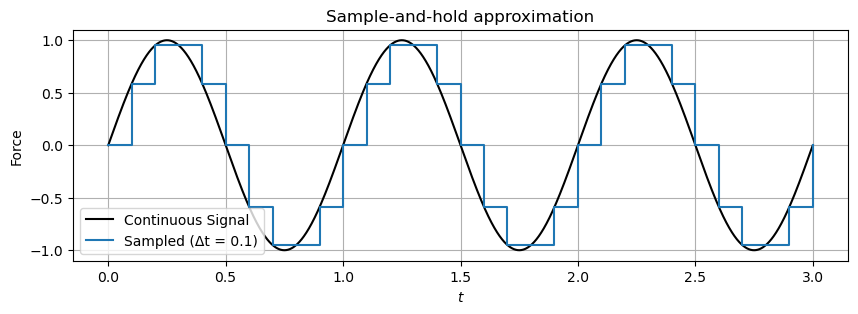

In [2]:
import numpy as np
import matplotlib.pyplot as plt

f=1 # Frequency of force
T=3

# Define a continuous signal (sine wave)
def sine_wave(t):
    return np.sin(2 * np.pi*f * t)

dt=0.1 # Time step

# Time for the continuous signal
t_continuous = np.linspace(0, T, 10000)

# Plot the continuous signal
plt.figure(figsize=(10, 3))
plt.plot(t_continuous, sine_wave(t_continuous), label='Continuous Signal', color='black')

# Plot signals sampled with space dt
t_sampled = np.arange(0, T + dt, dt)
sampled_signal = sine_wave(t_sampled)
    
# Use the `step` function to create a stair plot
plt.step(t_sampled, sampled_signal, where='post', label=f'Sampled (Δt = {dt})')

# Add labels and legend
plt.title('Sample-and-hold approximation')
plt.xlabel('$t$')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.show()



## Truss structure

<center>
<img src="figures\truss.svg">
</center>

We will use the truss structure from Exercise 6 as an example. We assume the mass and stiffness matrices are already constructed.



Although state space models are capable of handling any type of damping matrix, we will for simplicity use a proportional damping matrix (Rayleigh):

$$\mathbf{C}=\alpha_1 \mathbf{M}+\alpha_2 \mathbf{K}, \quad \alpha_1=10^{-2}, \quad \alpha_2=10^{-3}$$

We start by importing $\mathbf{M}$, $\mathbf{K}$, and the node data which are stored as csv-files.

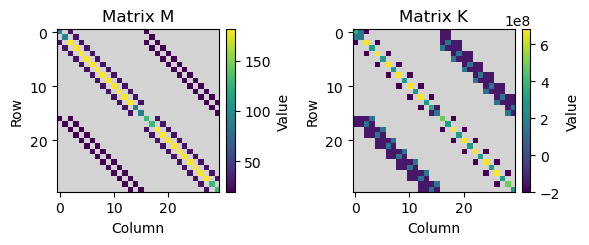

In [10]:
import csv

# Open the CSV file and read it into a NumPy array
def csv_to_numpy_array(file_path):
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        data = list(reader)
    
    # Convert the list of lists to a NumPy array
    return np.array(data).astype(float)

nodes=csv_to_numpy_array('truss/nodes.csv')
elements=csv_to_numpy_array('truss/elements.csv')
M=csv_to_numpy_array('truss/truss_mass_matrix.csv')
K=csv_to_numpy_array('truss/truss_stiffness_matrix.csv')

C=0.01*M+0.001*K

# Visualize M and K side by side

# Function to mask zeros
def mask_zeros(A):
    A_masked = np.ma.masked_where(A == 0, A)  # mask zeros
    return A_masked

# Colormap with grey for masked values
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='lightgrey')

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(6,3))

im0 = axes[0].imshow(mask_zeros(M), cmap=cmap, interpolation='none')
axes[0].set_title('Matrix M')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label='Value')

im1 = axes[1].imshow(mask_zeros(K), cmap=cmap, interpolation='none')
axes[1].set_title('Matrix K')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label='Value')

plt.tight_layout()
plt.show()

The figure confirms that the matrices have been imported correctly. Note that most elements in $\mathbf{K}$ and $\mathbf{M}$ are zero!

The state space model is given by:

$$ \dot{\mathbf{x}} = \mathbf{A}\mathbf{x} + \mathbf{B}\mathbf{f}(t)   $$

$$\mathbf{A} = \left[ {\begin{array}{c} {\mathbf{0}}&{\mathbf{I}}\\ {-\mathbf{M}^{-1} \mathbf{K}}&{-\mathbf{M}^{-1} \mathbf{C}} \end{array}} \right]  
,
\quad
\mathbf{B} = \left[ \begin{array}{c} \mathbf{0} \\ \mathbf{M}^{-1} \end{array} \right]   $$


We will simulate the response by using the discrete time forward model:

$$
\mathbf{x}_{k+1} = \mathbf{A}_\text{d} \mathbf{x}_{k} + \mathbf{B}_\text{d} \mathbf{f}_{k}
$$


$$ \mathbf{A}_\text{d} =\exp(\mathbf{A} \Delta t) $$

$$ \mathbf{B}_\text{d}=(\mathbf{A}_\text{d}-\mathbf{I}) \mathbf{A}^{-1} \mathbf{B} $$

### Free vibration

We first consider a case of free vibration. A static load of $Q_1 = 10$ kN has been applied, leading to a static deformation. The load is then released, and the bridge is in free vibration ($\mathbf{f}(t)=\mathbf{0}$) .


We have to define the initial conditions. The initial velocity is zero: $\mathbf{\dot{u}}_0=\mathbf{0}$. The displacements $\mathbf{u}_0$ can be found by a static solution:
$$ \mathbf{K} \mathbf{u}_0 = \mathbf{f}_0 $$

$$
 \mathbf{f}_0 = \left[ \begin{array}{c} 
0 \: , \: 0 \: , \: \dots \: , \: Q_1   \: , \: \dots \: , \: 0 \: , \: 0 \:
\end{array} \right]^\text{T}
$$

Here, $\mathbf{u}$ contains all degrees of freedom. We have to introduce the boundary conditions using a transformation matrix $\mathbf{u}_0 = \mathbf{T}_{bc} \mathbf{u}_{bc,0} $:

$$ \mathbf{T}_{bc}^\text{T} \mathbf{K}_{bc} \mathbf{T}_{bc} \mathbf{u}_{bc,0} = \mathbf{K}_{bc} \mathbf{u}_{bc,0} = \mathbf{T}_{bc}^\text{T} \mathbf{f}_0 $$

We find the displacements by the inverse:

$$ \mathbf{u}_{bc,0} =  \mathbf{K}_{bc}^{-1}  \mathbf{T}_{bc}^\text{T} \mathbf{f}_0 $$



In [4]:
# Boundary conditions
T_bc = np.eye(nodes.shape[0]*2)
T_bc = np.delete(T_bc,[0, 1 , 2*7+1],axis=1) # Delete two DOFs left support and 1 DOF at right support

# Reduce matrices
K_bc = T_bc.T @ K @ T_bc
M_bc = T_bc.T @ M @ T_bc
C_bc = T_bc.T @ C @ T_bc

Max deformation is 0.571 mm


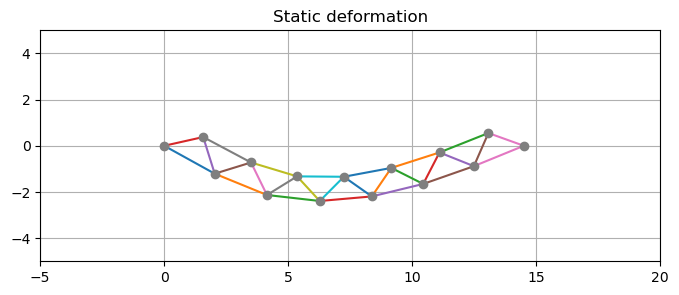

In [5]:

f0=np.zeros((15*2,1)) # Static force vector
f0[5]=-1000*10 # Apply to DOF 6

f_bc0=T_bc.T @ f0

u_bc0 = np.linalg.inv(K_bc) @ f_bc0

u0=T_bc@u_bc0

scale=1000.0

# Take original nodes, add a displacement according to the deflection
nodes_deformed = np.copy(nodes)
nodes_deformed[:,1] = nodes_deformed[:,1]+scale*u0[0::2].flatten()
nodes_deformed[:,2] = nodes_deformed[:,2]+scale*u0[1::2].flatten()

plt.figure(figsize=(8,3))
for k in range(elements.shape[0]):

    # Find indices of the nodes that define the current element
    node_idx1 = np.where(nodes[:, 0] == elements[k, 1])[0][0]  # Index of node 1
    node_idx2 = np.where(nodes[:, 0] == elements[k, 2])[0][0]  # Index of node 2
    
    x1 = nodes_deformed[node_idx1, 1:]  # Coordinates of node 1 
    x2 = nodes_deformed[node_idx2, 1:]  # Coordinates of node 2

    # Plot one element
    plt.plot([x1[0],x2[0]],[x1[1],x2[1]])

plt.plot(nodes_deformed[:,1],nodes_deformed[:,2],'o')
plt.title('Static deformation')
plt.xlim(-5,20)
plt.ylim(-5,5)
plt.grid()

print('Max deformation is ' + '{:.3f}'.format(np.max(u0)*1000) + ' mm')

Since we have found the initial conditions and the bridge is in free vibration, we set the force equal to zero. The forward model is then:

$$
\mathbf{x}_{k+1} = \mathbf{A}_\text{d} \mathbf{x}_{k}
$$

with initial state:

$$ \mathbf{x}_0 = \left[ \begin{array}{c}
\mathbf{u}_{bc,0} \\
\mathbf{0} 
\end{array} \right]   $$


Text(0.5, 1.0, 'Dynamic response at location of Q1')

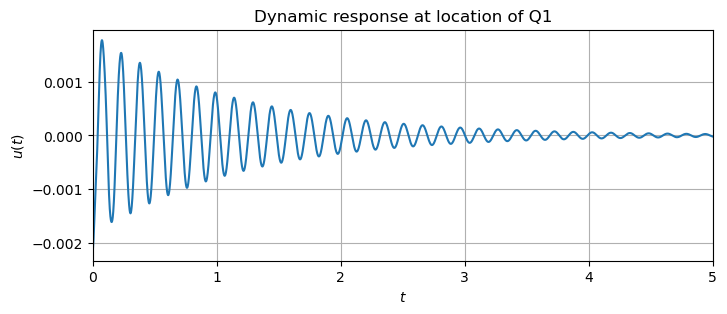

In [12]:
import scipy

# State-space A-matrix
A = np.block([
    [np.zeros_like(M_bc), np.eye(M_bc.shape[0])],
    [-np.linalg.inv(M_bc) @ K_bc, -np.linalg.inv(M_bc) @ C_bc]
])

# State-space B-matrix
B = np.block([
    [np.zeros_like(M_bc)],
    [np.linalg.inv(M_bc)]
])

dt=0.001 # Time step

Ad=scipy.linalg.expm(A*dt) # Remember to use the matrix exponential, not np.exp 
Bd = (Ad - np.eye(A.shape[0])) @ np.linalg.inv(A) @ B

udot_bc0=np.zeros_like(u_bc0) # Initial velocity
x0=np.vstack((u_bc0,udot_bc0)) # Initial state

T=5
N=int(T/dt)
t=np.arange(0,N,1)*dt # Time axis

x=np.zeros((len(x0),len(t))) # State vector

x[:,0]=x0.flatten() # Assign initial condition

# Discrete time forward model
for k in np.arange(len(t)-1):

    # Propagate model one step forward
    x[:, k+1] = Ad @ x[:, k]

u_bc= x[0:len(u_bc0),:] # Select upper half of state vector (displacements)

u=T_bc @ u_bc # Reconstruct full vector

# Plot response
plt.figure(figsize=(8,3))
plt.plot(t,u[5,:]) # Plot DOF 6 (at load)
plt.ylabel(r'$u(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()
plt.title('Dynamic response at location of Q1')


The free vibation response is dominated by one mode.


### Sine sweep 

We now look at the response under forcing. The load is still applied as $Q_1$. The load is a sine sweep:

$$
Q_1(t)= 10^3 \sin(\omega(t) \cdot t)
$$

This is a harmonic type of load, except that the forcing frequency $\omega(t)$ is not constant but is gradually increased over time.

The load vector is defined as:
$$
 \mathbf{f}(t) = \left[ \begin{array}{c} 
0 \: , \: 0 \: , \: \dots \: , \: Q_1(t)   \: , \: \dots \: , \: 0 \: , \: 0 \:
\end{array} \right]^\text{T}
$$

We now simulate using the forward model with forcing:

$$
\mathbf{x}_{k+1} = \mathbf{A}_\text{d} \mathbf{x}_{k} + \mathbf{B}_\text{d} \mathbf{f}_{k}
$$

We set initial conditions to zero.

Text(0.5, 1.0, 'Dynamic response at location of Q1')

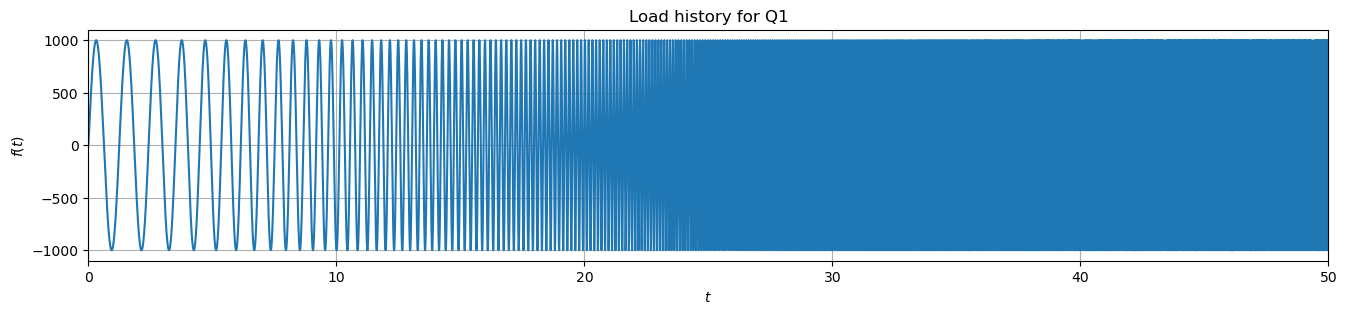

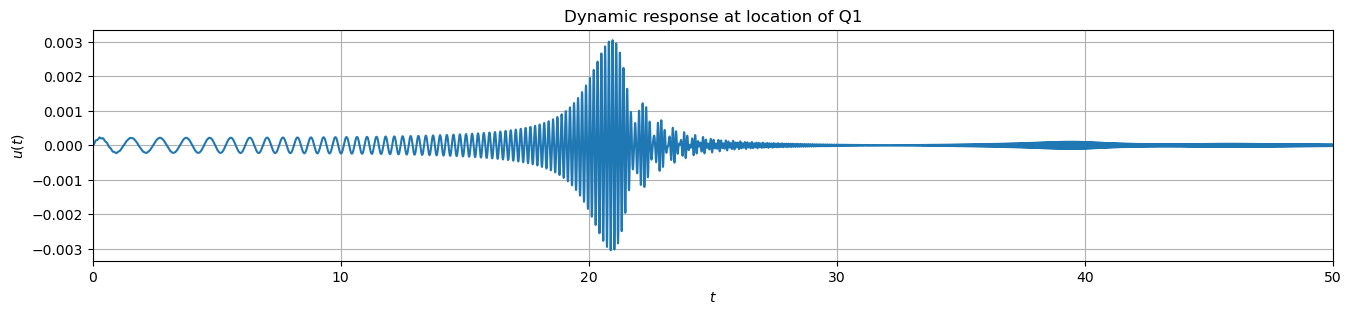

In [16]:
T=50
N=int(T/dt)
t=np.arange(0,N,1)*dt # Time axis

omega_low=5
omega_up=80
omega_sweep=omega_low*(1-(t/T)**2)+omega_up*(t/T)**2 # Gradual increase of frequency

Q1=1e3*np.sin(omega_sweep*t) # Sine sweep load

f=np.zeros((15*2,len(t))) # Load vector
f[5,:]=Q1  # Apply to DOF 6

f_bc=T_bc.T@f # Reduced load vector

x=np.zeros((len(x0),len(t))) # State vector

# Discrete time forward model
for k in np.arange(len(t)-1):

    # Propagate model one step forward
    x[:, k+1] = Ad @ x[:, k] + Bd @ f_bc[:,k]

u_bc= x[0:len(u_bc0),:] # Select upper half of state vector (displacements)
u=T_bc @ u_bc # Reconstruct full vector

# Plot time series load
plt.figure(figsize=(16,3))
plt.plot(t,Q1)
plt.ylabel(r'$f(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()
plt.title('Load history for Q1')

# Plot time series load
plt.figure(figsize=(16,3))
plt.plot(t,u[5,:])
plt.ylabel(r'$u(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()
plt.title('Dynamic response at location of Q1')
